<a href="https://colab.research.google.com/github/kaiu85/stable-diffusion-workshop/blob/main/Cool_Applications/inpainting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# In-painting pipeline for Stable Diffusion using 🧨 Diffusers

This notebook shows how to do text-guided in-painting with Stable Diffusion model using  🤗 Hugging Face [🧨 Diffusers library](https://github.com/huggingface/diffusers).

For a general introduction to the Stable Diffusion model please refer to this [colab](https://colab.research.google.com/github/kaiu85/stable-diffusion-workshop/blob/main/stable_diffusion.ipynb).

First, let us check again, if our instance is using a (GPU) graphics card to accelerate our computations. If yes, then !nvidia-smi should print out some informations, such as GPU type (likely Tesla T4), GPU memory (around 15GB), ...
If this command fails, you can change the runtime settings via "Runtime -> Change runtime type" (German: "Laufzeit -> Laufzeittyp ändern") and select "GPU".

In [1]:
!nvidia-smi

Tue May 14 12:06:40 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   59C    P8              10W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

Now let us install the fantastic diffusers library and some other required libraries again.

In [2]:
!pip install -qq -U diffusers==0.6.0 transformers ftfy gradio==3.50.2
!pip install git+https://github.com/huggingface/diffusers.git

  Cloning https://github.com/huggingface/diffusers.git to /tmp/pip-req-build-v0iv1b01
  Running command git clone --filter=blob:none --quiet https://github.com/huggingface/diffusers.git /tmp/pip-req-build-v0iv1b01
  Resolved https://github.com/huggingface/diffusers.git to commit cbea5d1725a09e7f45a145bbeb4fab7539b0faa0
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for diffusers: filename=diffusers-0.28.0.dev0-py3-none-any.whl size=2128377 sha256=93ae814ffbc6862159de00eb903f77cd016c3c93c5237b520707fdf6dfd74144
  Stored in directory: /tmp/pip-ephem-wheel-cache-yyu6amsx/wheels/4d/b7/a8/6f9549ceec5daad78675b857ac57d697c387062506520a7b50
Successfully built diffusers
  Attempting uninstall: diffusers
    Found existing installation: diffusers 0.6.0
    Uninstalling diffusers-0.6.0:
      Successfully uninstalled diffusers-0.6.0


Remember, that for in-painting, i.e. "filling holes" in a picture using a diffusion-model, the U-net has to be trained differently: It now also has to take the given image parts as an additional input (together with the text prompt), so that it can generate the missing parts consistently.

In this post we'll use the `runwayml/stable-diffusion-inpainting` model released by Runwayml so you'll need to  visit [its Huggingface model-card](https://huggingface.co/runwayml/stable-diffusion-inpainting) while being logged-in, read the license and tick the checkbox if you agree.

If you accept the license while being logged-in with an account, for which you already have created an access token, you will be able to just use this token to log into Hugging face and download the pre-trained model. You can generate new tokens and view your existing tokens here: https://huggingface.co/settings/tokens.

In [3]:
from huggingface_hub import notebook_login

notebook_login()

Now let's import the ``StableDiffusionInpaintPipeline`` and some other useful packages.

In [4]:
import inspect
from typing import List, Optional, Union

import numpy as np
import torch

import PIL
from PIL import Image
import gradio as gr
from diffusers import StableDiffusionInpaintPipeline

Now we can generate an inpainting pipeline object and move it to the GPU ( ```
device = "cuda"``).

In [5]:
device = "cuda"
model_path = "runwayml/stable-diffusion-inpainting"

pipe = StableDiffusionInpaintPipeline.from_pretrained(
    model_path,
    revision="fp16",
    torch_dtype=torch.float16,
    use_auth_token=True
).to(device)

Cannot initialize model with low cpu memory usage because `accelerate` was not found in the environment. Defaulting to `low_cpu_mem_usage=False`. It is strongly recommended to install `accelerate` for faster and less memory-intense model loading. You can do so with: 
```
pip install accelerate
```
.
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/diffusers/pipelines/pipeline_loading_utils.py:219: FutureWarning: You are loading the variant fp16 from runwayml/stable-diffusion-inpainting

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/transformers/models/clip/feature_extraction_clip.py:28: FutureWarning: The class CLIPFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use CLIPImageProcessor instead.
  warnings.warn(


As in previous notebooks, we define a helper function "image_grid", which just lets us display multiple images in a nice grid view.

In [6]:
import requests
from io import BytesIO

def image_grid(imgs, rows, cols):
    assert len(imgs) == rows*cols

    w, h = imgs[0].size
    grid = PIL.Image.new('RGB', size=(cols*w, rows*h))
    grid_w, grid_h = grid.size

    for i, img in enumerate(imgs):
        grid.paste(img, box=(i%cols*w, i//cols*h))
    return grid

In the next code cells, we download an image and a mask image. The mask image tells the pipeline, which pixels of the image should be replaced by samples from the latent-diffusion model (white) and which pixels should be kept (black).

In [7]:
# Dowload the image
!wget https://raw.githubusercontent.com/CompVis/latent-diffusion/main/data/inpainting_examples/overture-creations-5sI6fQgYIuo.png

--2024-05-14 12:12:22--  https://raw.githubusercontent.com/CompVis/latent-diffusion/main/data/inpainting_examples/overture-creations-5sI6fQgYIuo.png
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... ^C


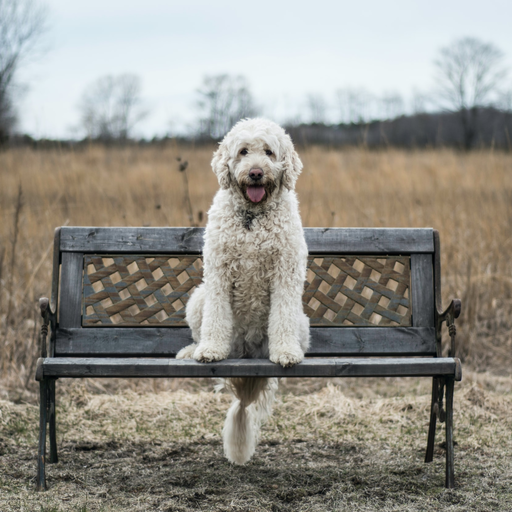

In [8]:
# Preprocess and display the image
filename = 'overture-creations-5sI6fQgYIuo.png'

image = Image.open(filename).convert("RGB")
image = image.resize((512, 512))
image

In [9]:
# Download the mask image
!wget https://raw.githubusercontent.com/CompVis/latent-diffusion/main/data/inpainting_examples/overture-creations-5sI6fQgYIuo_mask.png

--2024-05-14 12:13:16--  https://raw.githubusercontent.com/CompVis/latent-diffusion/main/data/inpainting_examples/overture-creations-5sI6fQgYIuo_mask.png
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 12106 (12K) [image/png]
Saving to: ‘overture-creations-5sI6fQgYIuo_mask.png.1’

overture-creations- 100%[===================>]  11.82K  --.-KB/s    in 0s      

2024-05-14 12:13:16 (88.2 MB/s) - ‘overture-creations-5sI6fQgYIuo_mask.png.1’ saved [12106/12106]



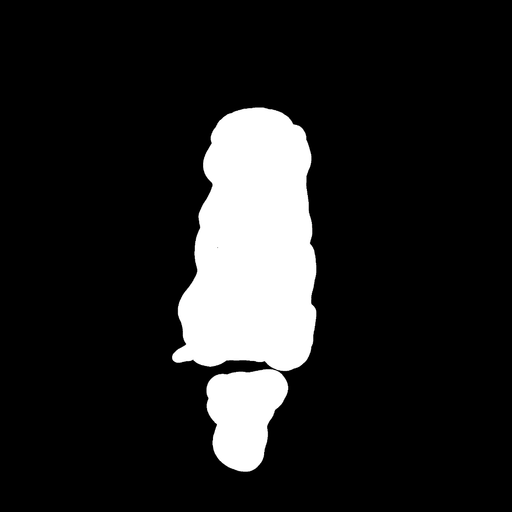

In [10]:
# Preprocess and display the mask image
filename = 'overture-creations-5sI6fQgYIuo_mask.png'

mask_image = Image.open(filename).convert("RGB")
mask_image = mask_image.resize((512, 512))
mask_image

Remember that the mask image tells the pipeline, which pixels of the image should be replaced (white) and which pixels should be kept (black).

Now let's define a prompt, which guides the generation process and see, how the generated results look like for three (``num_samples``) samples.

In [12]:
prompt = "a tucan sitting on a bench"

guidance_scale=7.5
num_samples = 3
generator = torch.Generator(device="cuda").manual_seed(0) # change the seed to get different results

images = pipe(
    prompt=prompt,
    image=image,
    mask_image=mask_image,
    guidance_scale=guidance_scale,
    generator=generator,
    num_images_per_prompt=num_samples,
).images

  0%|          | 0/50 [00:00<?, ?it/s]

To compare the in-painted images with the original image, we add the original images as first item to the list ``images``.

In [13]:
# insert initial image in the list so we can compare side by side
images.insert(0, image)

Now we display the list of images using our ``image_grid`` function (with a single row).

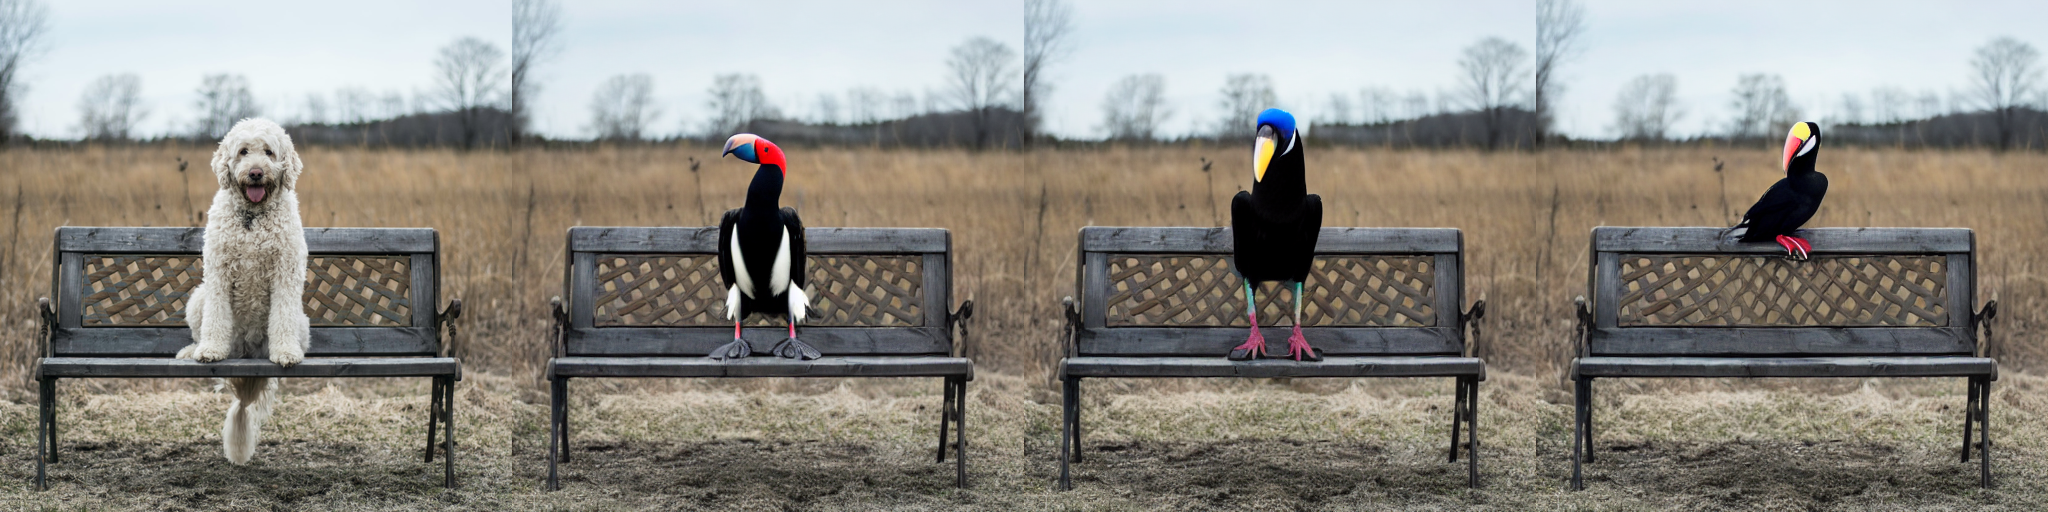

In [14]:
image_grid(images, 1, num_samples + 1)

To work with your own images, you can just open the file explorer on the left (Bildschirm­foto 2022-11-17 um 17.37.59.png-Icon) and upload (Bildschirm­foto 2022-11-17 um 17.42.25.png-Icon) your own image and mask image files and change the filenames in the above cells accordingly.

However, creating the mask files require you to use some image editing software ([GIMP](https://www.gimp.org) is a great, free and open source image editing software, but takes some time to learn).

Thus, to make experimenting with your own images easier and more fun, we will use the ``gradio`` package in the next few cells, to generate a **graphical user interface**, which lets you upload images and mask them easily.

### Interactive Gradio Demo

First we install the gradio package and import it as ``gr``.

In [15]:
#!pip install -q gradio
import gradio as gr

Gradio needs a function, which it can call to generate an inpainted image, based on an image, a mask image, and a prompt. Thus, we define such a function in the next cell.

In [16]:
def predict(dict, prompt):
  image =  dict['image'].convert("RGB").resize((512, 512))
  mask_image = dict['mask'].convert("RGB").resize((512, 512))
  images = pipe(prompt=prompt, image=image, mask_image=mask_image).images
  return(images[0])

The next few lines of code just create a very simple user interface, where you can upload and mask an image (``gr.Image``) and add a text prompt (``gr.Textbox``).

In [ ]:
gr.Interface(
    predict,
    title = 'Stable Diffusion In-Painting',
    inputs=[
        gr.Image(source = 'upload', tool = 'sketch', type = 'pil'),
        gr.Textbox(label = 'prompt')
    ],
    outputs = [
        gr.Image()
        ]
).launch(debug=True)

IMPORTANT: You are using gradio version 3.50.2, however version 4.29.0 is available, please upgrade.
--------
Setting queue=True in a Colab notebook requires sharing enabled. Setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. This cell will run indefinitely so that you can see errors and logs. To turn off, set debug=False in launch().
Running on public URL: https://a27cbe572374544f0b.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from Terminal to deploy to Spaces (https://huggingface.co/spaces)


# Assignment

Again, please take your time to **play with the model**. Try different input images, try masking out different regions, and see how a prompt can change the inpainted results. Try also **filling the mask regions with an empty ('') prompt**. This way you can explore, what your model expects to be in the masked-out regions, when it is not guided by an additional text prompt.

**Please** collect suprisingly good, suprisingly bad, funny and interesting results [here](https://docs.google.com/presentation/d/1n5P9JIyYoISbRIfRgXvwmXFdETlPm1FQ_S7WuqKgqBo/edit?usp=sharing). Feel free to also add links, thoughts and comments, which you want to share with the group.